In [70]:
import pandas as pd
import numpy as np
from kiteconnect import KiteConnect, KiteTicker
import login
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import pytz
import pymongo
import os
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [71]:
# Access environment variables
user_name = os.getenv("KITE_USER_NAME")
password = os.getenv("KITE_PASSWORD")
totp = os.getenv("KITE_TOTP")
api_key = os.getenv("KITE_API_KEY")
api_secret = os.getenv("KITE_API_SECRET")

kite = KiteConnect(api_key=api_key)
request_token = login.kiteLogin(user_name, password, totp, api_key)
data = kite.generate_session(request_token, api_secret)
kite.set_access_token(data["access_token"])

In [72]:
instrument_dump = kite.instruments()   # get instruments dump from NSE
instrument_df = pd.DataFrame(instrument_dump)  # dump it to a dataframe
print(instrument_df.columns)

Index(['instrument_token', 'exchange_token', 'tradingsymbol', 'name',
       'last_price', 'expiry', 'strike', 'tick_size', 'lot_size',
       'instrument_type', 'segment', 'exchange'],
      dtype='object')


In [73]:
def getInstrumentToken(symbol):
    #return none if not found
    if len(instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values)==0:
        return None
    return instrument_df[(instrument_df['tradingsymbol']==symbol) & (instrument_df['exchange']=='NSE')]['instrument_token'].values[0]

In [75]:
import pandas_market_calendars as mcal
#get next trading day
def get_next_trading_day(date):
    nyse = mcal.get_calendar('XNYS')
    schedule = nyse.schedule(start_date=date, end_date=date + timedelta(days=10))
    next_date = mcal.date_range(schedule, frequency='1D')[1]  # Get the next trading day
    return next_date.strftime('%Y-%m-%d')

def check_prior_data(symbol,date):
    #get the instrument token
    instrument_token=getInstrumentToken(symbol)
    #get the data for the stock for the prior one year
    to_date = datetime.strptime(date, '%Y-%m-%d')
    from_date = to_date - relativedelta(years=1)

    #get the next trading day of from date
    from_date = get_next_trading_day(from_date)
    
    #get the data for the stock for the from_date
    data = kite.historical_data(instrument_token, from_date, from_date, 'day')
    #change the data to dataframe
    data = pd.DataFrame(data)
    #check if the data is available
    if data.empty:
        return False
    return True

print(check_prior_data('MEDIASSIST','2021-06-01'))


False


In [5]:
#get the list of finserv stocks from instrument dump
bse_stocks=pd.read_csv('bse.csv')
#keep only Financial Services stocks
bse_stocks=bse_stocks[bse_stocks['Sector Name']=='Financial Services']
#reset the index
bse_stocks.reset_index(drop=True,inplace=True)

token_list=[]
#get the security id and check if it is present in the instrument dump with exchange as NSE
for index, row in bse_stocks.iterrows():
    symbol=row['Security Id']
    # print(symbol)
    token=getInstrumentToken(symbol)
    # print(token)
    if token:
        # print(symbol,token)
        token_list.append(token)
    else:
        # print('Token not found for symbol:',symbol)
        #remove the row from the dataframe
        bse_stocks.drop(index,inplace=True)

#add token list to the dataframe
bse_stocks['Token']=token_list
#remove if Industry == Mutual Fund Scheme - ETF
final_env=bse_stocks[bse_stocks['Industry']!='Mutual Fund Scheme - ETF'].copy()
#reset the index
final_env.reset_index(drop=True,inplace=True)
#set the index to 'Security Id'
final_env.set_index('Security Id',inplace=True)
#first sort accourding to 'Security Id' and then 'Industry'
final_env.sort_values(by=['Industry','Security Id'],inplace=True)
print(final_env)

             Security Code                                 Issuer Name  \
Security Id                                                              
ABSLAMC             543374           Aditya Birla Sun Life AMC Limited   
HDFCAMC             541729       HDFC Asset Management Company Limited   
IVC                 511208            IL & FS Investment Managers Ltd.   
NAM-INDIA           540767  NIPPON LIFE INDIA ASSET MANAGEMENT LIMITED   
UTIAMC              543238        UTI Asset Management Company Limited   
...                    ...                                         ...   
MOTILALOFS          532892    Motilal Oswal Financial Services Limited   
NUVAMA              543988            Nuvama Wealth Management Limited   
ONELIFECAP          533632                Onelife Capital Advisors Ltd   
SHAREINDIA          540725              Share India Securities Limited   
SMCGLOBAL           543263               SMC Global Securities Limited   

                                     

In [6]:
def calculate_moment_score(df):
    if len(df) < 2:
        return np.nan
    # Get the pct change from the first to the last value
    pct_change = (df['close'].iloc[-1] / df['close'].iloc[0] - 1)
    # Get the std of pct change
    pct_change_std = np.std(df['close'].pct_change())
    if pct_change_std == 0:
        return np.nan
    score_value = pct_change / pct_change_std
    return score_value


#fuction to get zscore accourding to each column
def get_zscore(df):
    for column in df.columns:
        # print(df[column])
        df[column] = (df[column] - df[column].mean())/df[column].std()
    return df
    

def get_moment_score(df,date):
        moment_dict = {}
        # print(df.head(10))
        symbollist = df.index.to_list()
        # print(symbollist)
        end_date = datetime.strptime(date, '%Y-%m-%d')
        start_date = end_date - relativedelta(years=1)
        start_date = start_date.strftime('%Y-%m-%d')

        for symbol in symbollist:
            # print(symbol)

            try:
                stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
                #make dataframe of the stock data
                stock_data = pd.DataFrame(stock_data)
                data_points = len(stock_data)
                six_month = stock_data.tail(data_points//2)
                data_points = len(six_month)
                three_month = six_month.tail(data_points//2)
                data_points = len(three_month)
                one_month = three_month.tail(data_points//3)
                data_points = len(one_month)
                two_week = one_month.tail(data_points//2)
                data_points = len(two_week)
                one_week = stock_data.tail(5)


                score_1y=calculate_moment_score(stock_data)
                socre_6m = calculate_moment_score(six_month)
                score_3m = calculate_moment_score(three_month)
                score_1m = calculate_moment_score(one_month)
                score_2w = calculate_moment_score(two_week)
                score_1w = calculate_moment_score(one_week)

                # print(socre_t,score_3m,score_1m,score_2w,score_1w,score_3d)

                row={'score_1y':score_1y,'score_6m':socre_6m,'score_3m':score_3m,'score_1m':score_1m,'score_2w':score_2w,'score_1w':score_1w}
                moment_dict[symbol] = row

            except:
                # print("Error in getting data for symbol: ", symbol)
                moment_dict[symbol] = {"Z_score_t": np.nan, "Z_score_3m": np.nan, "Z_score_1m": np.nan, "Z_score_2w": np.nan, "Z_score_1w": np.nan, "Z_score_3d": np.nan}

        moment_score_results = pd.DataFrame(moment_dict).T
        # print(moment_score_results)
        moment_score_results = get_zscore(moment_score_results)
        return moment_score_results
        # df['Moment Score'] = moment_score_results['Moment_score']

        # return df

# get the moment score for the stocks
date='2024-01-01'
moment_score_df = get_moment_score(final_env,date)

In [7]:
final_env.loc[:, 'Industry'] = final_env['Industry'].str.strip()
final_env.loc[:, 'Igroup Name'] = final_env['Igroup Name'].str.strip()

moment_score_df['Industry']=final_env['Industry']
moment_score_df['Igroup Name']=final_env['Igroup Name']
print(moment_score_df)


            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
ABSLAMC    -0.792437  0.668973  0.039775  0.597039  0.066946  0.074105   
HDFCAMC     0.359248  0.968079  1.279046  1.566078  1.550444  0.078333   
IVC         0.050899  0.092234  0.685670  0.484535 -1.089363  0.073519   
NAM-INDIA   1.337553  1.648244  1.460367  0.028726  0.528328  0.076717   
UTIAMC     -0.891093 -0.591265  0.241358  0.185326 -0.031093  0.082871   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  0.855625  1.075095  1.002266  0.262335  0.290427  0.073353   
NUVAMA     -0.266369 -0.039282 -0.058505 -0.644096       NaN  0.070443   
ONELIFECAP -0.715831 -0.186557 -0.402564 -1.948839 -0.184408  0.075463   
SHAREINDIA  0.339878  0.697557  1.646388  0.476676 -0.145188  0.075019   
SMCGLOBAL   0.078503  0.441051  0.707073  0.033433 -0.259643  0.076225   

                            Industry      Igroup Name  
ABSLAMC     Asset Management Company  Capital Markets  

In [15]:
#calulate beta for each stock
def get_beta(stock_df, market_df):
    try:
        stock_df['Returns'] = stock_df['close'].pct_change()

        market_df['Market Returns'] = market_df['close'].pct_change()

        stock_df = stock_df.dropna()
        stock_df = stock_df.reset_index(drop=True)

        market_df = market_df.dropna()
        market_df = market_df.reset_index(drop=True)

        beta = np.cov(stock_df['Returns'], market_df['Market Returns'])[0][1] / np.var(market_df['Market Returns'])
    except:
        beta = np.nan
    # print(beta)
    return beta

def get_mean_returns(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].pct_change()
    stock_return_mean = np.mean(stock_return)
    return stock_return_mean

def calculate_returns(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].iloc[-1] / stock_df['close'].iloc[0] - 1
    return stock_return

def calculate_expected_returns(beta,market_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    return expected_return

def calculate_risk_std(stock_df):
    if stock_df.empty or 'close' not in stock_df.columns or len(stock_df) < 2:
        return None
    stock_return = stock_df['close'].pct_change()
    stock_return_std = np.std(stock_return)
    return stock_return_std


def get_beta_score(df,date):
        
    # print(df.head(10))
    symbollist = df.index.to_list()
    # print(symbollist)
    end_date = datetime.strptime(date, '%Y-%m-%d')
    start_date = end_date - relativedelta(years=1)
    start_date = start_date.strftime('%Y-%m-%d')

    beta_dict={}
    i=0

    one_year_market_data = kite.historical_data(getInstrumentToken('NIFTY 50'), start_date, end_date, "day")
    #make dataframe of the stock data
    one_year_market_data = pd.DataFrame(one_year_market_data)
    data_points = len(one_year_market_data)
    six_month_market_data = one_year_market_data.tail(data_points//2)
    data_points = len(six_month_market_data)
    three_month_market_data = six_month_market_data.tail(data_points//2)
    data_points = len(three_month_market_data)
    one_month_market_data = three_month_market_data.tail(data_points//3)
    data_points = len(one_month_market_data)
    two_week_market_data = one_month_market_data.tail(data_points//2)
    data_points = len(two_week_market_data)
    one_week_market_data = one_month_market_data.tail(5)

    #calulate returns for each time period
    market_return_1y=calculate_returns(one_year_market_data)
    market_return_6m=calculate_returns(six_month_market_data)
    market_return_3m=calculate_returns(three_month_market_data)
    market_return_1m=calculate_returns(one_month_market_data)
    market_return_2w=calculate_returns(two_week_market_data)
    market_return_1w=calculate_returns(one_week_market_data)    

    market_returns={'market_return_1y':market_return_1y,'market_return_6m':market_return_6m,'market_return_3m':market_return_3m,'market_return_1m':market_return_1m,'market_return_2w':market_return_2w,'market_return_1w':market_return_1w}    

    data_points = len(one_year_market_data)
    for symbol in symbollist:
        # print(symbol)
        one_year_stock_data = kite.historical_data(getInstrumentToken(symbol), start_date, end_date, "day")
        #make dataframe of the stock data
        one_year_stock_data = pd.DataFrame(one_year_stock_data)
        data_points = len(one_year_stock_data)



        #6 month data
        six_month_stock_data = one_year_stock_data.tail(data_points//2)
        # data_points = len(six_month_stock_data)
        six_month_market_data = one_year_market_data.tail(data_points//2)
        data_points = len(six_month_market_data)
        #reset the index
        six_month_stock_data.reset_index(drop=True,inplace=True)
        six_month_market_data.reset_index(drop=True,inplace=True)

        #3 month data
        three_month_stock_data = six_month_stock_data.tail(data_points//2)
        # data_points = len(three_month_stock_data)
        three_month_market_data = six_month_market_data.tail(data_points//2)
        data_points = len(three_month_market_data)

        #1 month data
        one_month_stock_data = three_month_stock_data.tail(data_points//3)
        # data_points = len(one_month_stock_data)
        one_month_market_data = three_month_market_data.tail(data_points//3)
        data_points = len(one_month_market_data)

        #2 week data
        two_week_stock_data = one_month_stock_data.tail(data_points//2)
        # data_points = len(two_week_stock_data)
        two_week_market_data = one_month_market_data.tail(data_points//2)
        data_points = len(two_week_market_data)

        #1 week data
        one_week_stock_data = one_month_stock_data.tail(5)
        # data_points = len(one_week_stock_data)
        one_week_market_data = one_month_market_data.tail(5)
        data_points = len(one_week_market_data)

        one_year_beta=get_beta(one_year_stock_data,one_year_market_data)
        six_month_beta=get_beta(six_month_stock_data,six_month_market_data)
        three_month_beta=get_beta(three_month_stock_data,three_month_market_data)
        one_month_beta=get_beta(one_month_stock_data,one_month_market_data)
        two_week_beta=get_beta(two_week_stock_data,two_week_market_data)
        one_week_beta=get_beta(one_week_stock_data,one_week_market_data)

        #calculate returns for each time period
        stock_return_1y=calculate_returns(one_year_stock_data)
        stock_return_6m=calculate_returns(six_month_stock_data)
        stock_return_3m=calculate_returns(three_month_stock_data)
        stock_return_1m=calculate_returns(one_month_stock_data)
        stock_return_2w=calculate_returns(two_week_stock_data)
        stock_return_1w=calculate_returns(one_week_stock_data)

        #calulate expected returns
        expected_return_1y=calculate_expected_returns(one_year_beta,market_return_1y)
        expected_return_6m=calculate_expected_returns(six_month_beta,market_return_6m)
        expected_return_3m=calculate_expected_returns(three_month_beta,market_return_3m)
        expected_return_1m=calculate_expected_returns(one_month_beta,market_return_1m)
        expected_return_2w=calculate_expected_returns(two_week_beta,market_return_2w)
        expected_return_1w=calculate_expected_returns(one_week_beta,market_return_1w)

        risk=calculate_risk_std(one_year_stock_data)
        mean_return=get_mean_returns(one_year_stock_data)


        row={'beta_1y':one_year_beta,'beta_6m':six_month_beta,'beta_3m':three_month_beta,'beta_1m':one_month_beta,'beta_2w':two_week_beta,'beta_1w':one_week_beta,
             'stock_return_1y':stock_return_1y,'stock_return_6m':stock_return_6m,'stock_return_3m':stock_return_3m,'stock_return_1m':stock_return_1m,'stock_return_2w':stock_return_2w,'stock_return_1w':stock_return_1w,
             'expected_return_1y':expected_return_1y,'expected_return_6m':expected_return_6m,'expected_return_3m':expected_return_3m,'expected_return_1m':expected_return_1m,'expected_return_2w':expected_return_2w,'expected_return_1w':expected_return_1w,
             'risk':risk,'mean_return':mean_return}
        beta_dict[symbol] = row

    beta_df=pd.DataFrame(beta_dict).T
    print(beta_df)
    return beta_df,market_returns
date='2024-01-01'

beta_score_df,market_return=get_beta_score(final_env,date)

             beta_1y   beta_6m   beta_3m   beta_1m   beta_2w   beta_1w  \
ABSLAMC     0.328809  0.077540 -0.061371 -0.319260 -0.497004 -0.750571   
HDFCAMC     1.139424  0.895020  0.679321  0.237485  0.461879  0.583256   
IVC         1.070525  1.694566  2.505413  5.934502  4.112399 -0.426011   
NAM-INDIA   0.740584  0.444768  0.397402 -1.390104 -2.204956 -4.849902   
UTIAMC      0.927286  0.996056  0.928252  0.867072  1.771217 -0.440369   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  0.995521  0.901259  1.062088  0.064971  0.957108 -5.712786   
NUVAMA           NaN  0.666529  0.946048 -0.164077       NaN -0.164077   
ONELIFECAP  0.843447  0.732344  1.039209  0.877756  2.379386 -0.739404   
SHAREINDIA  0.681027  0.459378  0.542002  0.855087  1.626510  1.971153   
SMCGLOBAL   0.375105  0.440720  0.472301  0.772460  2.417544  0.150089   

            stock_return_1y  stock_return_6m  stock_return_3m  \
ABSLAMC            0.038980         0.274547  

In [16]:
print(market_return)

{'market_return_1y': 0.19477729022472934, 'market_return_6m': 0.12080315488310966, 'market_return_3m': 0.11863491132480308, 'market_return_1m': 0.051003538488311406, 'market_return_2w': 0.015091987590254208, 'market_return_1w': 0.01401730767885434}


In [17]:
def get_alpha_score(beta,market_return,stock_return):
    rfr=0.07
    expected_return=rfr+beta*(market_return-rfr)
    jensen_alpha=stock_return-expected_return
    return jensen_alpha


def calculate_alpha_score(beta_score_df,market_return):
    alpha_score={}
    for index,row in beta_score_df.iterrows():
        for time_period in ['1y','6m','3m','1m','2w','1w']:
            beta=row['beta_'+time_period]
            stock_return=row['stock_return_'+time_period]
            #market return is a dictionary
            market_returns=market_return['market_return_'+time_period]
            alpha=get_alpha_score(beta,market_returns,stock_return)
            beta_score_df.loc[index,'alpha_'+time_period]=alpha

            #calculate zscore for columns containing alpha
    zscore=get_zscore(beta_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])
    
    return zscore

alpha_score_df=calculate_alpha_score(beta_score_df,market_return)


In [18]:
#normalize the alpha and moment score
def normalize(df):
    for column in df.columns:
        for index in df.index:
            val=df.loc[index,column]
            if val==np.nan:
                df.loc[index,column]=0
            elif val>0:
                df.loc[index,column]=1+val
            else:
                df.loc[index,column]=1/(1-val)
    return df

moment_score_df=normalize(moment_score_df[['score_1y','score_6m','score_3m','score_1m','score_2w','score_1w']])
alpha_score_df=normalize(alpha_score_df[['alpha_1y','alpha_6m','alpha_3m','alpha_1m','alpha_2w','alpha_1w']])

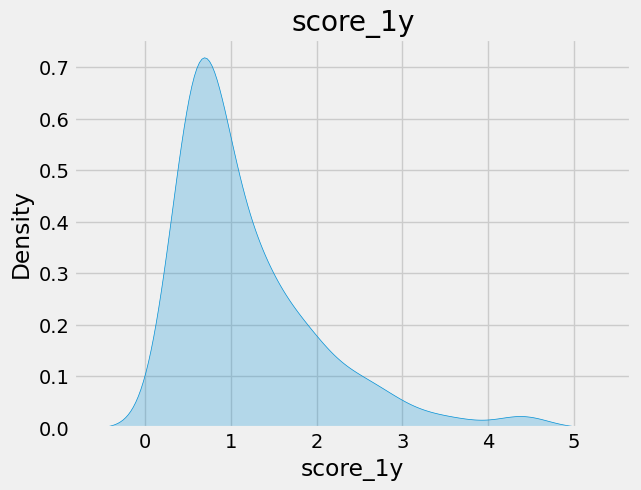

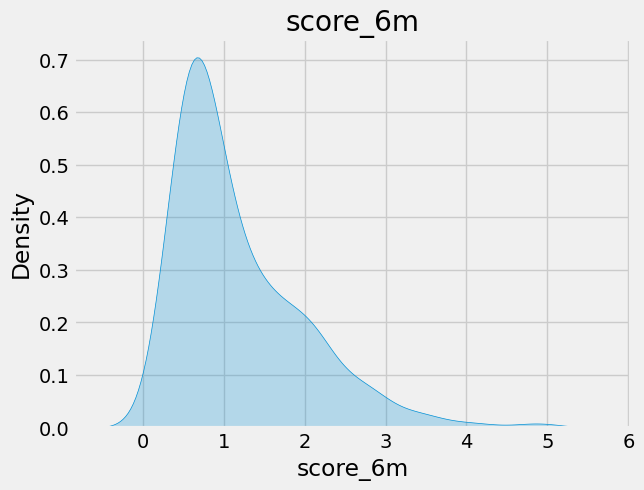

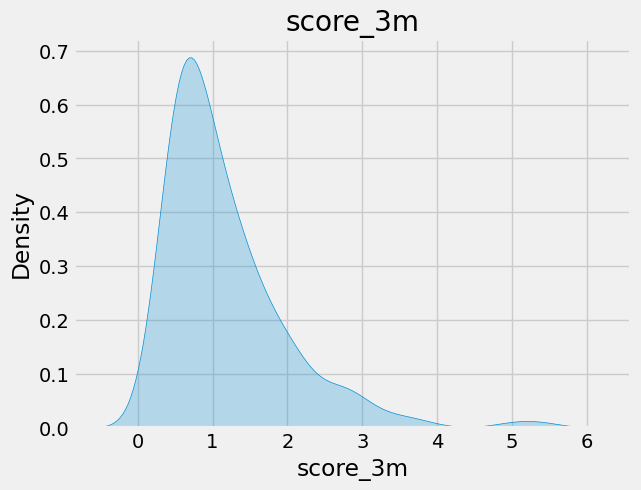

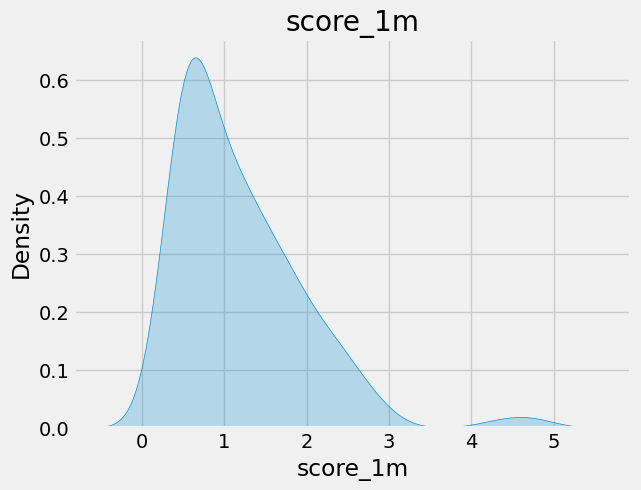

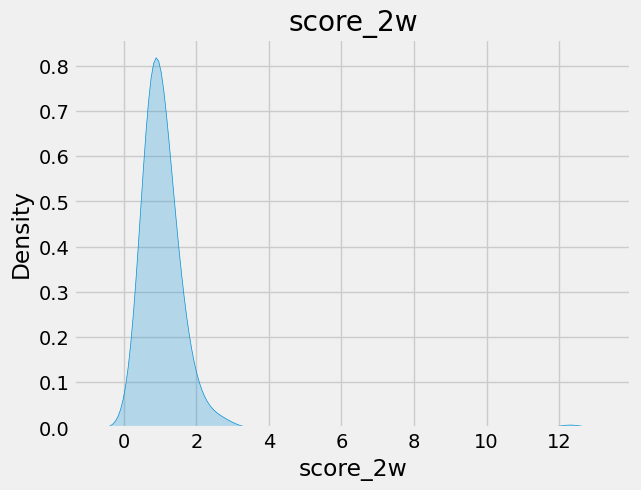

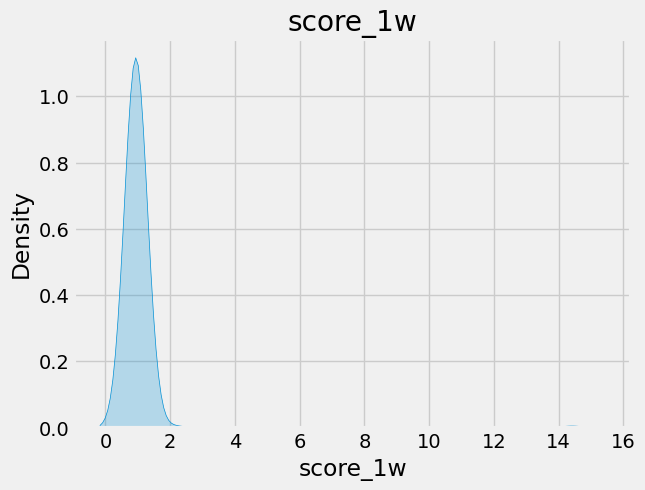

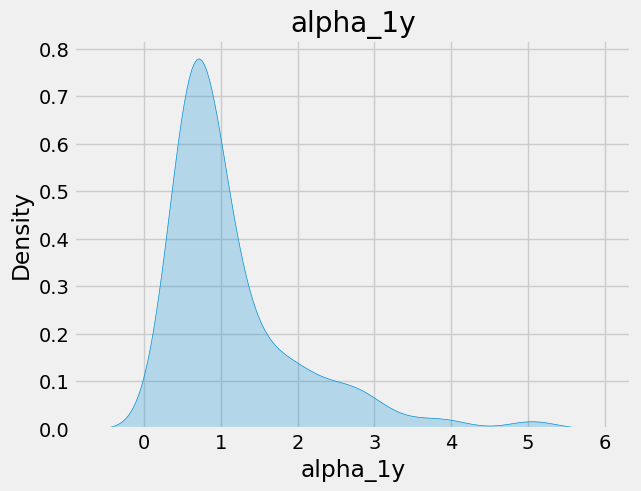

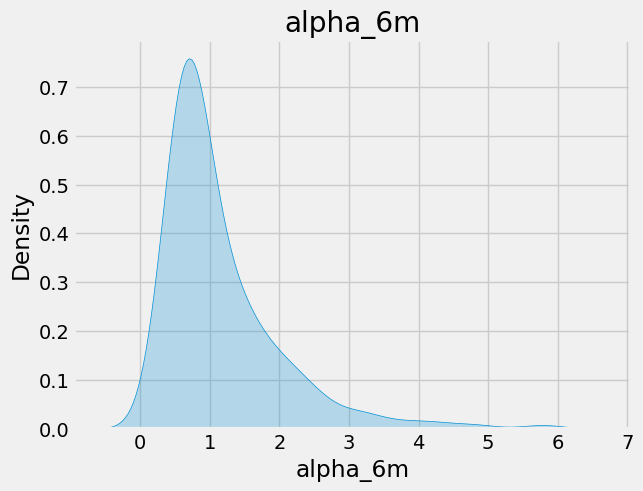

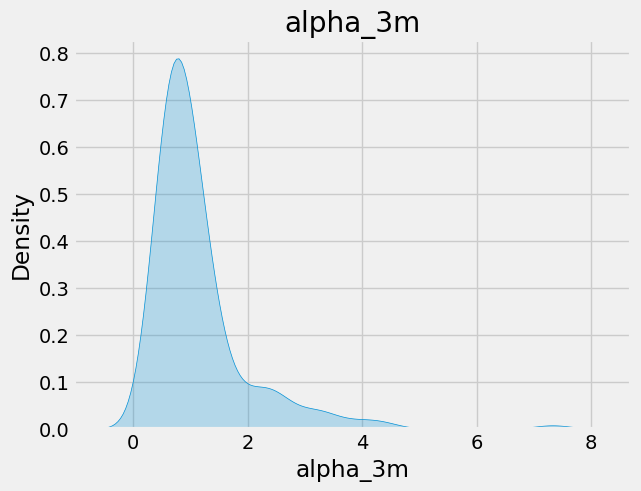

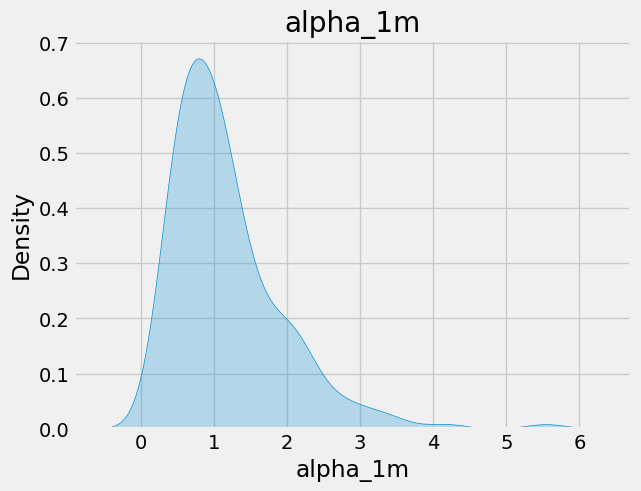

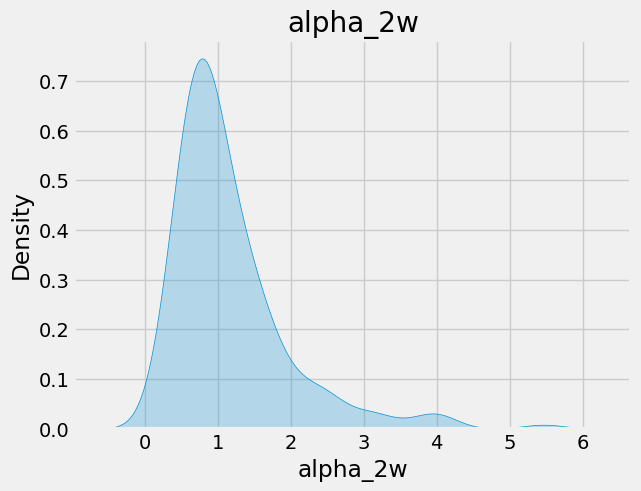

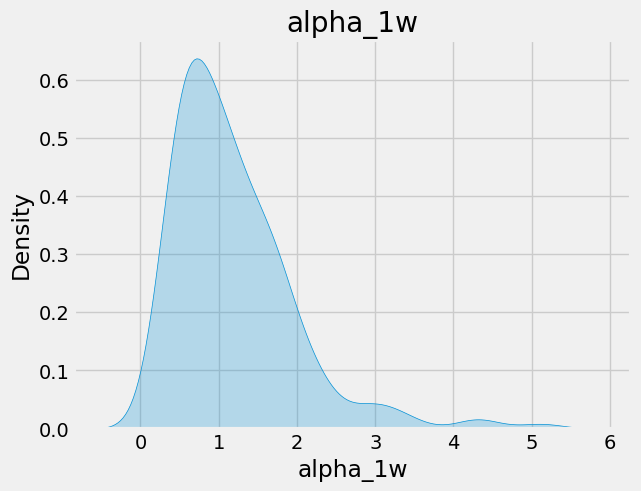

In [ ]:
# # Plot normal distribution for each moment score and alpha score
# import seaborn as sns
# import matplotlib.pyplot as plt

# for column in moment_score_df.columns:
#     if moment_score_df[column].dtype == 'float64':
#         sns.kdeplot(moment_score_df[column], fill=True)
#         plt.title(column)
#         plt.show()

# for column in alpha_score_df.columns:
#     if alpha_score_df[column].dtype == 'float64':
#         sns.kdeplot(alpha_score_df[column], fill=True)
#         plt.title(column)
#         plt.show()

In [19]:
#add column of alpha and moment score to the final score 
final_score_df=pd.concat([moment_score_df,alpha_score_df],axis=1)
print(final_score_df)

            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
ABSLAMC     0.557900  1.668973  1.039775  1.597039  1.066946  1.074105   
HDFCAMC     1.359248  1.968079  2.279046  2.566078  2.550444  1.078333   
IVC         1.050899  1.092234  1.685670  1.484535  0.478615  1.073519   
NAM-INDIA   2.337553  2.648244  2.460367  1.028726  1.528328  1.076717   
UTIAMC      0.528795  0.628431  1.241358  1.185326  0.969845  1.082871   
...              ...       ...       ...       ...       ...       ...   
MOTILALOFS  1.855625  2.075095  2.002266  1.262335  1.290427  1.073353   
NUVAMA      0.789660  0.962202  0.944729  0.608237       NaN  1.070443   
ONELIFECAP  0.582808  0.842774  0.712980  0.339116  0.844303  1.075463   
SHAREINDIA  1.339878  1.697557  2.646388  1.476676  0.873219  1.075019   
SMCGLOBAL   1.078503  1.441051  1.707073  1.033433  0.793876  1.076225   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  
ABSLAMC     0.582183  0.921298  0.8860

In [20]:
#calulate final moment score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_moment_score']=0.3*final_score_df['score_1m']+0.5*final_score_df['score_3m']+0.2*final_score_df['score_6m']


#calulate final alpha score as 0.3 to 1m 0.5 to 3m and 0.2 to 6m
final_score_df['final_alpha_score']=0.3*final_score_df['alpha_1m']+0.5*final_score_df['alpha_3m']+0.2*final_score_df['alpha_6m']

#compute final score as 0.5 to final moment score and 0.5 to final alpha score
final_score_df['final_score']=0.5*final_score_df['final_moment_score']+0.5*final_score_df['final_alpha_score']

#sort the final score in descending order
final_score_df.sort_values(by='final_score',ascending=False,inplace=True)
print(final_score_df)

            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
SUVIDHAA    1.548994  3.577361  6.047403  7.229159  4.041862  1.083811   
TIMESGTY    1.964675  2.365533  2.594154  3.493897  2.609592  1.067247   
ANGELONE    3.399365  2.582366  4.397099  2.519272  2.018964  1.098536   
STARTECK    1.689986  1.454457  2.530277  2.210965  1.904008  0.071040   
IIFLSEC     2.190865  3.248084  2.652838  2.253935  1.426789  1.072773   
...              ...       ...       ...       ...       ...       ...   
MANCREDIT        NaN       NaN       NaN       NaN       NaN       NaN   
UYFINCORP        NaN       NaN       NaN       NaN       NaN       NaN   
CAPITALSFB       NaN       NaN       NaN       NaN       NaN       NaN   
ESAFSFB     0.516356  0.504001  0.592629       NaN       NaN  1.068019   
JSFB             NaN       NaN       NaN       NaN       NaN       NaN   

            alpha_1y  alpha_6m  alpha_3m  alpha_1m  alpha_2w  alpha_1w  \
SUVIDHAA    2.016025  4.208867  5.937

In [22]:
#select top 20 stocks
final_list=final_score_df.head(30)

#print the columns of beta_score_df
print(beta_score_df.columns)

#add expected return of three months and expected return of six months to the final list
# final_list['return_1m']=beta_score_df.loc[final_list.index,'stock_return_1m']
# final_list['stock_return_3m']=beta_score_df.loc[final_list.index,'stock_return_3m']
# final_list['stock_return_6m']=beta_score_df.loc[final_list.index,'stock_return_6m']

# #add risk to the final list
# final_list['risk']=beta_score_df.loc[final_list.index,'risk']

# #change 6m to 1m return using compounding of stock return
# final_list['return_6m']=((1+final_list['stock_return_6m'])**(1/6))-1
# #change 3m to 1m return using compounding
# final_list['return_3m']=((1+final_list['stock_return_3m'])**(1/3))-1
# #calculate the weighted return for 1m,3m and 6m
# # final_list['weighted_return']=0.3*final_list['return_1m']+0.5*final_list['return_3m']+0.2*final_list['return_6m']
# # print(final_list)
final_list['weighted_return']=beta_score_df.loc[final_list.index,'mean_return']

#remove stocks with negative expected 
final_list=final_list[final_list['weighted_return']>0]
#sort the final list by name of the stock
final_list.sort_index(inplace=True)
print(final_list)

Index(['beta_1y', 'beta_6m', 'beta_3m', 'beta_1m', 'beta_2w', 'beta_1w',
       'stock_return_1y', 'stock_return_6m', 'stock_return_3m',
       'stock_return_1m', 'stock_return_2w', 'stock_return_1w',
       'expected_return_1y', 'expected_return_6m', 'expected_return_3m',
       'expected_return_1m', 'expected_return_2w', 'expected_return_1w',
       'risk', 'mean_return', 'alpha_1y', 'alpha_6m', 'alpha_3m', 'alpha_1m',
       'alpha_2w', 'alpha_1w'],
      dtype='object')
            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
360ONE      1.618532  1.798896  2.595583  2.002732  1.723517  1.080694   
5PAISA      1.962071  1.338869  2.556635  2.418558  2.709922  1.085502   
ANANDRATHI  6.937465  6.013277  2.656098  0.521971  1.262752  1.071941   
ANGELONE    3.399365  2.582366  4.397099  2.519272  2.018964  1.098536   
GEOJITFSL   1.635729  1.897293  2.353634  1.767465  1.081890  1.072992   
GICRE       1.191667  2.035776  1.979511  0.724298  0.842215  1.072617   
HDF

In [34]:
portfolio=pd.DataFrame()
for index, row in final_list.iterrows():
    # print(index)
    instrument_token = getInstrumentToken(index)
    # print(instrument_token)

    #get last one month data for each stock
    to_date = '2024-01-01'
    to_date = datetime.strptime(to_date, '%Y-%m-%d')
    from_date = to_date - relativedelta(years=1)
    from_date = from_date.strftime('%Y-%m-%d')
    # print(from_date, to_date)
    data = kite.historical_data(instrument_token, from_date, to_date, 'day')
    #change the data to dataframe
    data = pd.DataFrame(data)
    data['pct_change'] = data['close'].pct_change()
    data = data[['date', 'pct_change']]
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    # print(data)

    #push the data to portfolio
    portfolio[index] = data['pct_change']
#remove the first row of the portfolio
portfolio = portfolio.iloc[1:]
display(portfolio)
    

,360ONE,5PAISA,ANANDRATHI,ANGELONE,GEOJITFSL,GICRE,HDFCAMC,HUDCO,IEX,IIFLSEC,...,PFC,PFS,PNB,RECLTD,SHAREINDIA,STARTECK,SUVIDHAA,TFCILTD,THEINVEST,TIMESGTY
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00+05:30,-0.004598,0.016987,0.001564,-0.000760,0.013618,0.045261,-0.000183,-0.008411,0.002812,0.017706,...,0.042171,0.027356,0.011374,0.021595,-0.012036,0.002909,-0.019048,0.000000,0.032276,-0.016814
2023-01-04 00:00:00+05:30,0.002141,-0.018420,0.016611,0.012884,0.002085,0.024198,-0.003950,-0.022620,-0.015072,-0.012103,...,-0.009615,-0.017751,-0.026817,-0.006504,-0.001239,-0.013416,0.000000,-0.018322,0.003840,0.010801
2023-01-05 00:00:00+05:30,0.006184,-0.004453,0.024928,-0.015797,-0.007166,-0.028600,0.008436,0.010608,-0.000356,0.000766,...,0.015372,0.000000,0.008889,0.013502,-0.000620,0.002205,-0.009709,-0.001806,-0.036066,0.007124
2023-01-06 00:00:00+05:30,-0.008157,-0.002236,0.010560,-0.023485,-0.011641,-0.074501,-0.029099,-0.008588,-0.009256,-0.017598,...,0.001594,-0.018072,-0.006167,-0.001211,-0.008275,0.003667,0.000000,-0.003619,0.026077,-0.043324
2023-01-09 00:00:00+05:30,0.003267,0.010247,0.017191,0.003279,0.000000,0.030982,0.017186,0.000000,0.016170,0.000779,...,0.013922,0.049080,0.012411,0.014956,0.000834,-0.023018,0.000000,0.084746,0.002762,0.032348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26 00:00:00+05:30,-0.009728,0.078926,0.002712,-0.001260,0.004344,-0.005730,-0.008086,-0.000947,0.025238,0.059680,...,0.013828,-0.015294,-0.008403,0.030497,0.000973,0.193248,0.045977,-0.023172,0.022149,0.049750
2023-12-27 00:00:00+05:30,0.035226,0.012438,-0.006511,0.008622,0.027627,0.004322,0.005930,0.080569,-0.010550,-0.006868,...,-0.018993,0.000000,0.037288,-0.020286,0.023330,-0.050000,0.049451,-0.024092,0.049793,-0.049936
2023-12-28 00:00:00+05:30,0.050930,0.009373,-0.022423,0.030921,-0.047658,0.000797,-0.000140,0.122807,0.043619,-0.020747,...,0.000260,0.010753,0.040305,-0.000609,-0.003528,-0.049936,0.047120,-0.029624,0.046113,-0.049883


In [35]:
#caluculate the correlation for portfolio
covariance = portfolio.cov()
covariance=covariance*250
print(covariance)

#get list of weighted returns for each stock
weighted_returns = final_list[['weighted_return']]*250
#compond it with 12 to get annual returns
# weighted_returns = ((1+weighted_returns)**12)-1
print(weighted_returns)

              360ONE    5PAISA  ANANDRATHI  ANGELONE  GEOJITFSL     GICRE  \
360ONE      0.089698 -0.004617   -0.002223  0.007925  -0.003678 -0.007199   
5PAISA     -0.004617  0.148902    0.009535  0.033696   0.026613  0.042647   
ANANDRATHI -0.002223  0.009535    0.096495  0.008838   0.013752  0.012317   
ANGELONE    0.007925  0.033696    0.008838  0.173126   0.037765  0.016465   
GEOJITFSL  -0.003678  0.026613    0.013752  0.037765   0.123794  0.027468   
GICRE      -0.007199  0.042647    0.012317  0.016465   0.027468  0.224597   
HDFCAMC     0.010491  0.020469    0.001273  0.013639   0.006342  0.030052   
HUDCO       0.022918  0.032698   -0.007414  0.027651   0.026080  0.066114   
IEX         0.010623  0.027836    0.005748  0.012545   0.026413  0.029165   
IIFLSEC    -0.010108  0.026956    0.013528  0.029089   0.061582  0.029455   
IRFC        0.023384  0.026711    0.008842  0.022057   0.027072  0.037277   
IVC         0.012097  0.026796    0.001186  0.036005   0.034232  0.022478   

In [36]:
#plot heatmap for covariance using plotly
import plotly.express as px
fig = px.imshow(covariance)
fig.show()

#compute correlation matrix
correlation = portfolio.corr()
fig = px.imshow(correlation)
fig.show()

In [51]:
portfolio_returns = []
portfolio_volatility = []

sharpe_ratio = []   

stock_weights = []  
num_assets = len(final_list)
num_portfolios = 100000

np.random.seed(3)
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    stock_weights.append(weights)
    returns = np.dot(weights, weighted_returns['weighted_return'])
    portfolio_returns.append(returns)
    portfolio_risk=np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    portfolio_volatility.append(portfolio_risk)

    #sharpe ratio
    sharpe = (returns-0.07)/portfolio_risk
    sharpe_ratio.append(sharpe)

In [52]:
# Storing the portfolio values
portfolio_final = {'Returns': portfolio_returns,
             'Volatility': portfolio_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Add an additional entry to the portfolio such that each indivudal weight is incorporated for its corresponding company
for counter,symbol in enumerate(final_list.index):
    portfolio_final[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio_final)

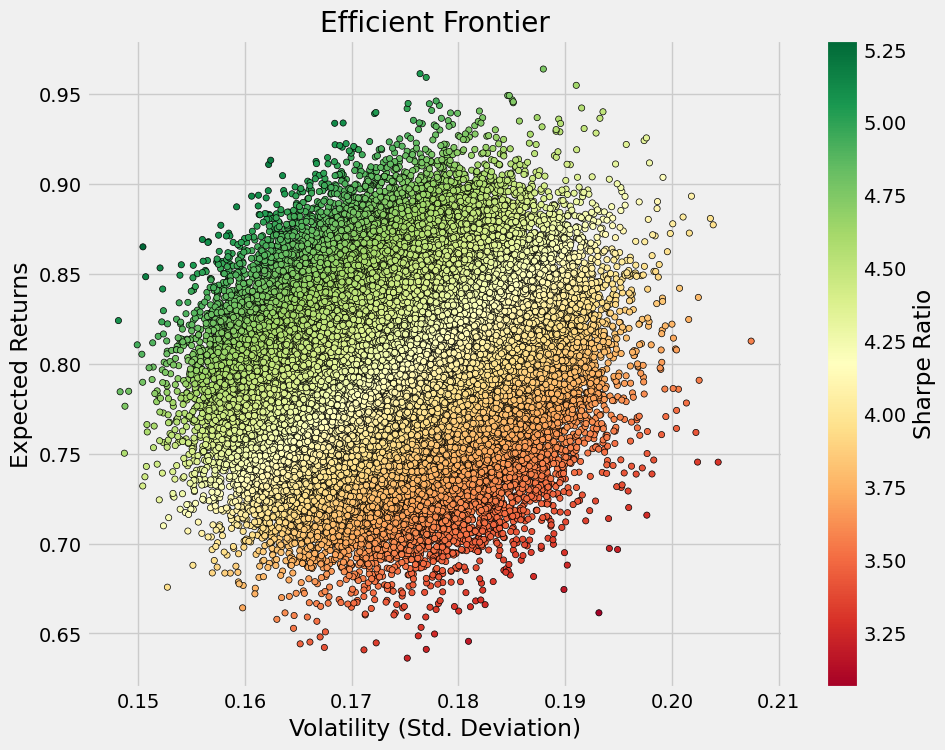

In [53]:
# PLotting the efficient frontier.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [56]:
import scipy.optimize as sc
def portfolio_performance(weights, returns, cov_matrix):
    returns=np.sum(returns*weights)
    std=np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights)))
    return returns,std

# to get maximum sharpe ratio, we can minimize negative sharpe ratio
def negative_sharpe_ratio(weights,returns,cov_matrix,rfr=0.07):
    p_ret,p_std=portfolio_performance(weights,returns,cov_matrix)
    return -(p_ret-rfr)/p_std

def maxSR(returns,cov_matrix):
    rfr=0.07
    constraintSet=(0,1)
    num_assets=len(returns)
    args=(returns,cov_matrix,rfr)
    constraints=({'type':'eq','fun':lambda x: np.sum(x)-1})
    bound=constraintSet
    bounds=tuple(bound for asset in range(num_assets))
    #optimize using SLSQP (Sequential Least Squares Programming) algorithm
    result=sc.minimize(negative_sharpe_ratio, num_assets*[1./num_assets,],args=args,method='SLSQP',bounds=bounds,constraints=constraints)
    return result

result=maxSR(weighted_returns['weighted_return'],covariance)
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -7.8044975945829735
       x: [ 9.809e-02  9.609e-15 ...  2.595e-02  4.498e-13]
     nit: 24
     jac: [-5.304e-01 -2.019e-02 ... -5.293e-01  7.969e+00]
    nfev: 771
    njev: 24


In [43]:
#multiply by 100 to get percentage and round off to 2 decimal places
display(np.round(result.x*100,2))

array([9.810e+00, 0.000e+00, 2.719e+01, 3.250e+00, 0.000e+00, 9.000e-02,
       5.700e-01, 3.020e+00, 0.000e+00, 3.180e+00, 2.000e-02, 0.000e+00,
       0.000e+00, 0.000e+00, 1.400e+01, 0.000e+00, 1.680e+01, 6.850e+00,
       0.000e+00, 0.000e+00, 7.660e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       2.610e+00, 2.370e+00, 0.000e+00, 0.000e+00, 2.590e+00, 0.000e+00])

In [ ]:
#finding global minimum variance portfolio

def portfolioVariance(weights, Returns, cov_matrix):
    return portfolio_performance(weights, Returns, cov_matrix)[1]

def minimizeVariance(meanReturns, covMatrix):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    constraintSet=(0,1)

    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

result = minimizeVariance(weighted_returns['weighted_return'], covariance)
print(result)
print(np.round(result.x*100,2)) 

In [47]:
def portfolioReturn(weights, meanReturns, covMatrix):
      return portfolio_performance(weights, meanReturns, covMatrix)[0]

def efficientFrontier(meanReturns, covMatrix, targetReturn):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0, 1)
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [ ]:
def calculate_results(returns,covariance):
    maxSR_portfolio= maxSR(returns,covariance)
    minVar_portfolio= minimizeVariance(returns,covariance)

    maxSR_portfolio_weights = np.round(maxSR_portfolio.x*100,2)
    minVar_portfolio_weights = np.round(minVar_portfolio.x*100,2)

    maxSR_portfolio_returns, maxSR_portfolio_risk = portfolio_performance(maxSR_portfolio_weights, returns, covariance)
    minVar_portfolio_returns, minVar_portfolio_risk = portfolio_performance(minVar_portfolio_weights, returns, covariance)

    return maxSR_portfolio_weights, minVar_portfolio_weights, maxSR_portfolio_returns, maxSR_portfolio_risk, minVar_portfolio_returns, minVar_portfolio_risk

maxSR_portfolio_weights, minVar_portfolio_weights, maxSR_portfolio_returns, maxSR_portfolio_risk, minVar_portfolio_returns, minVar_portfolio_risk = calculate_results(weighted_returns['weighted_return'], covariance)


print("Max Sharpe Ratio Portfolio Weights: ", maxSR_portfolio_weights)
print("Min Variance Portfolio Weights: ", minVar_portfolio_weights)
print("Max Sharpe Ratio Portfolio Returns: ", maxSR_portfolio_returns)
print("Max Sharpe Ratio Portfolio Risk: ", maxSR_portfolio_risk)
print("Min Variance Portfolio Returns: ", minVar_portfolio_returns)
print("Min Variance Portfolio Risk: ", minVar_portfolio_risk)

#add the weights to the final list
final_list['maxSR_portfolio_weights']=maxSR_portfolio_weights
final_list['minVar_portfolio_weights']=minVar_portfolio_weights

print(final_list)


Max Sharpe Ratio Portfolio Weights:  [9.810e+00 0.000e+00 2.719e+01 3.250e+00 0.000e+00 9.000e-02 5.700e-01
 3.020e+00 0.000e+00 3.180e+00 2.000e-02 0.000e+00 0.000e+00 0.000e+00
 1.400e+01 0.000e+00 1.680e+01 6.850e+00 0.000e+00 0.000e+00 7.660e+00
 0.000e+00 0.000e+00 0.000e+00 2.610e+00 2.370e+00 0.000e+00 0.000e+00
 2.590e+00 0.000e+00]
Min Variance Portfolio Weights:  [12.45  0.   14.51  0.    0.    0.    7.44  0.    6.8   3.66  0.    0.
 12.9   0.   11.92  0.   13.76  5.39  0.    0.    0.    0.    1.93  0.
  5.66  0.    0.    0.    3.58  0.  ]
Max Sharpe Ratio Portfolio Returns:  109.98305222187487
Max Sharpe Ratio Portfolio Risk:  13.195257580134246
Min Variance Portfolio Returns:  78.00189199097075
Min Variance Portfolio Risk:  10.878591688799292
            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
360ONE      1.618532  1.798896  2.595583  2.002732  1.723517  1.080694   
5PAISA      1.962071  1.338869  2.556635  2.418558  2.709922  1.085502   
ANANDRATHI  6

In [ ]:
import pandas_market_calendars as mcal
from datetime import datetime, timedelta

def get_next_trading_day(date):
    nyse = mcal.get_calendar('XNYS')
    schedule = nyse.schedule(start_date=date, end_date=date + timedelta(days=10))
    next_date = mcal.date_range(schedule, frequency='1D')[1]  # Get the next trading day
    return next_date.strftime('%Y-%m-%d')

2024-11-13


In [67]:
#select the stocks with maxSR_portfolio_weights
maxSR_portfolio_stocks=final_list[final_list['maxSR_portfolio_weights']>0]
print(maxSR_portfolio_stocks)

#make a portfolio of stocks with maxSR_portfolio_weights
portfolio=pd.DataFrame()

#buy stock on nexr trading day of date
date='2024-01-01'
date = datetime.strptime(date, '%Y-%m-%d')
next_date = get_next_trading_day(date)

returns = {}

for index, row in maxSR_portfolio_stocks.iterrows():
    # print(index)
    instrument_token = getInstrumentToken(index)
    # print(instrument_token)

    #get next month data for each stock
    from_date = datetime.strptime(next_date, '%Y-%m-%d')
    to_date = from_date + relativedelta(months=1)
    # print(from_date, to_date)
    data = kite.historical_data(instrument_token, from_date, to_date, 'day')
    #change the data to dataframe
    data = pd.DataFrame(data)
    #get one month return by taking the last value and dividing by the first value
    one_month_return=data['close'].iloc[-1]/data['close'].iloc[0]-1
    # print(one_month_return)
    data_push={'one_month_return':one_month_return,'weight':row['maxSR_portfolio_weights']}
    returns[index]=data_push

#make a dataframe of the returns
returns_df=pd.DataFrame(returns).T
print(returns_df)


            score_1y  score_6m  score_3m  score_1m  score_2w  score_1w  \
360ONE      1.618532  1.798896  2.595583  2.002732  1.723517  1.080694   
ANANDRATHI  6.937465  6.013277  2.656098  0.521971  1.262752  1.071941   
ANGELONE    3.399365  2.582366  4.397099  2.519272  2.018964  1.098536   
GICRE       1.191667  2.035776  1.979511  0.724298  0.842215  1.072617   
HDFCAMC     1.359248  1.968079  2.279046  2.566078  2.550444  1.078333   
HUDCO       2.539194  2.695423  1.864078  3.092415  1.921843  1.083200   
IIFLSEC     2.190865  3.248084  2.652838  2.253935  1.426789  1.072773   
IRFC        3.443045  4.118289  1.746795  2.631164  1.543609  1.078080   
MCX         2.700671  3.421336  3.545917  0.932355  0.860026  1.075159   
MUFIN       0.645530  0.971358  0.610674  0.654887       NaN  1.066254   
NAM-INDIA   2.337553  2.648244  2.460367  1.028726  1.528328  1.076717   
PFC         4.976673  3.600553  3.373851  1.185101  0.770580  1.073804   
SHAREINDIA  1.339878  1.697557  2.6463

In [69]:
#multiply the returns with the weights
returns_df['weighted_return']=returns_df['one_month_return']*returns_df['weight']
returns_df['weighted_return']=returns_df['weighted_return']*100
print(returns_df)

print(returns_df['weighted_return'].sum()/100)

            one_month_return  weight  weighted_return
360ONE             -0.076765    9.81       -75.306066
ANANDRATHI          0.264460   27.19       719.067462
ANGELONE           -0.040539    3.25       -13.175045
GICRE               0.214228    0.09         1.928054
HDFCAMC             0.101815    0.57         5.803444
HUDCO               0.640379    3.02       193.394322
IIFLSEC             0.093483    3.18        29.727738
IRFC                0.674430    0.02         1.348860
MCX                 0.150289   14.00       210.404242
MUFIN               0.380234   16.80       638.792367
NAM-INDIA           0.098348    6.85        67.368507
PFC                 0.146782    7.66       112.435004
SHAREINDIA          0.062354    2.61        16.274329
STARTECK           -0.063140    2.37       -14.964286
THEINVEST           0.238039    2.59        61.652036
19.547509688313138
